In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB

The titanic data set contains three tables 
(1) train - the training data containing informations for all the passengers: Name, PassengerClass (Pclass), Sex, Age, SibSp, Parch, Ticket Number (Ticket), Fare, Cabin, Port of Embarkment (Embarked)
(2) gender - example prediction output where all the instances are female passengers
(3) test - same format as the training data, but used for 

In [2]:
test = pd.read_csv('data/test.csv')
gender = pd.read_csv('data/gender_submission.csv')
train = pd.read_csv('data/train.csv')

Focus on the traning data only for now <br>
* what are the data types of each features
* how many NaN values are there in each feature

In [3]:
# create a copy of the original dataset
train_copy = train.copy(deep = True)

print('Datatypes of each feature: \n', train_copy.info())

print("Numbers of NaN values in training data: \n", train_copy.isnull().sum(),
      "\nTotal number of variables: ", train_copy.shape[0])

train_copy

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Datatypes of each feature: 
 None
Numbers of NaN values in training data: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket          

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<h4>
In the Training data, there are a lot of NaN in Age, Embark, and Cabin
</h4>

<ol>
<li>Sex (str) [Categorical]</li>
<li>Age (int64) [Continous]</li>
<li>Pclass (int64) [Categorical]</li>
<li>Fare (flaot64) [Continous]</li>
<li>Embarked (str) [Categorical]</li>
<li>SibSp (int) [Continous]</li>
<li>Parch (int) [Continous]</li>
</ol>
<p>
First I am going to see what is the distribution of all the feature data
</p>

<AxesSubplot:xlabel='Parch', ylabel='Count'>

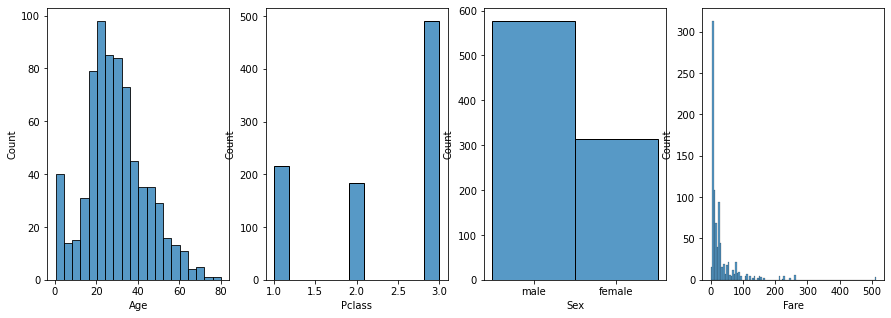

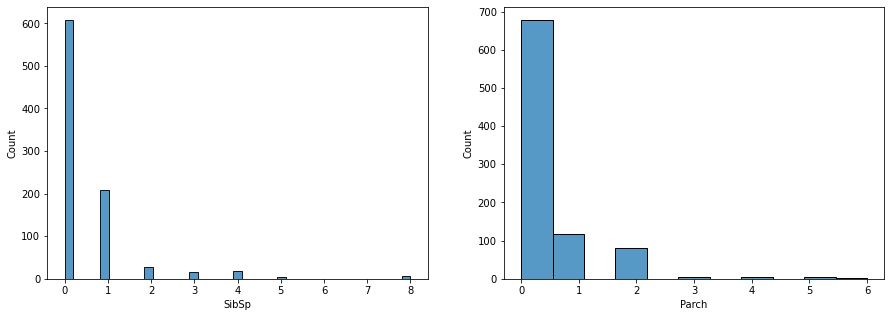

In [4]:
# distribution of each continuous feature
figure, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
sns.histplot(data=train_copy["Age"], ax=axs[0])
sns.histplot(data=train_copy['Pclass'], ax=axs[1])
sns.histplot(data=train_copy['Sex'], ax=axs[2])
sns.histplot(data=train_copy['Fare'], ax=axs[3])

figure2, axs2 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=train_copy["SibSp"], ax=axs2[0])
sns.histplot(data=train_copy['Parch'], ax=axs2[1])

Now after seeing the plot for Age and other features, we can replace the NaN continuous data with the median value and
the

In [5]:
# now only retain the wanted features
features = ['Sex', 'Age', 'Fare', 'Pclass', 'Embarked', 'SibSp', 'Parch', 'Survived']
train_features = train_copy[features].copy(deep=True)

# replace the NaN value in 'Age' and 'Embarked' using fillna()
train_features['Age'].fillna(train_copy['Age'].median(), inplace=True)
train_features['Embarked'].fillna(train_copy['Embarked'].mode()[0], inplace=True)

train_features.isnull().sum()

Sex         0
Age         0
Fare        0
Pclass      0
Embarked    0
SibSp       0
Parch       0
Survived    0
dtype: int64

After all the NaN values are replaced in the selected features, then we have to codify categorical data using
scikit-learn's preprocessing package

In [6]:
# fit Age and Fare into bins; turning continuous data to categorical with cut() and qcut()
train_features['FareBin'] = pd.qcut(train_features['Fare'], 3)
train_features['AgeBin'] = pd.cut(train_features['Age'].astype(int), 5)

# siblings and parents count can be combined into family member count
train_features['FamilyCount'] = train_features['SibSp'] + train_features['Parch'] + 1
# and then family count can be categorized into Alone vs NotAlone
train_features['IsAlone'] = 1
train_features['IsAlone'].loc[train_features['FamilyCount'] > 1] = 0

# Labelencodor(): encode categorical data
label = preprocessing.LabelEncoder()
# encode each categorical feature
for feature in ['Sex', 'Embarked', 'AgeBin', 'FareBin']:
    train_features[feature+'_Code'] = label.fit_transform(train_features[feature])
train_features

C:\ProgramData\Miniconda3\envs\SFHack_TODO\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Sex,Age,Fare,Pclass,Embarked,SibSp,Parch,Survived,FareBin,AgeBin,FamilyCount,IsAlone,Sex_Code,Embarked_Code,AgeBin_Code,FareBin_Code
0,male,22.0,7.2500,3,S,1,0,0,"(-0.001, 8.662]","(16.0, 32.0]",2,0,1,2,1,0
1,female,38.0,71.2833,1,C,1,0,1,"(26.0, 512.329]","(32.0, 48.0]",2,0,0,0,2,2
2,female,26.0,7.9250,3,S,0,0,1,"(-0.001, 8.662]","(16.0, 32.0]",1,1,0,2,1,0
3,female,35.0,53.1000,1,S,1,0,1,"(26.0, 512.329]","(32.0, 48.0]",2,0,0,2,2,2
4,male,35.0,8.0500,3,S,0,0,0,"(-0.001, 8.662]","(32.0, 48.0]",1,1,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,male,27.0,13.0000,2,S,0,0,0,"(8.662, 26.0]","(16.0, 32.0]",1,1,1,2,1,1
887,female,19.0,30.0000,1,S,0,0,1,"(26.0, 512.329]","(16.0, 32.0]",1,1,0,2,1,2
888,female,28.0,23.4500,3,S,1,2,0,"(8.662, 26.0]","(16.0, 32.0]",4,0,0,2,1,1
889,male,26.0,30.0000,1,C,0,0,1,"(26.0, 512.329]","(16.0, 32.0]",1,1,1,0,1,2


Now:
* extrapolate the observed target as standalone list, 'Survived'
* setup lists with feature names for later convenience

In [7]:
# get the observation
response = ['Survived']

# original names
normal_names = ['Sex','Age','Pclass','Embarked','SibSp','Parch','Fare','FamilyCount', 'IsAlone']
# feature names (used for training models)
feature_names = ['Sex_Code', 'Pclass', 'Embarked_Code', 'SibSp', 'Parch', 'Age', 'Fare']
# feature names with bins
bin_names = ['Sex_Code', 'Pclass', 'Embarked_Code', 'FamilyCount', 'AgeBin_Code', 'FareBin_Code']

# combined feature and response list with bins
bin_feature_response = bin_names + response

* split the training data into training and testing portions

In [8]:
# split original and binned data
train1_x, test1_x, train1_y, test1_y = \
    model_selection.train_test_split(train_features[normal_names], train_features[response], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = \
    model_selection.train_test_split(train_features[bin_names], train_features[response] , random_state = 0)

print("Original Shape: {}".format(train_features.shape))
print("Binned Shape: {}".format(train1_x.shape))


Original Shape: (891, 16)
Binned Shape: (668, 9)


It is time to repeat some Exploratory Analysis with Statistics


<ipython-input-9-a2d5751ddb6b>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-9-a2d5751ddb6b>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


TypeError: 'Text' object is not callable

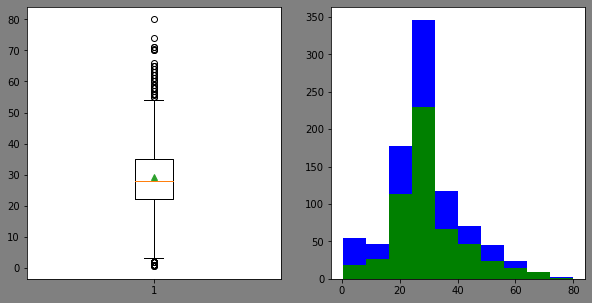

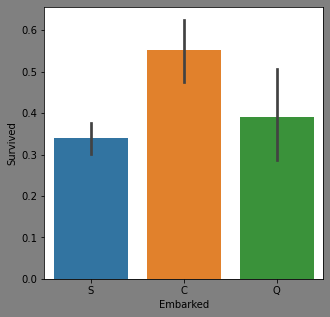

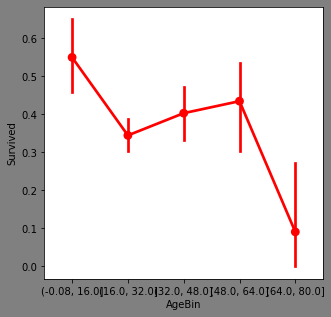

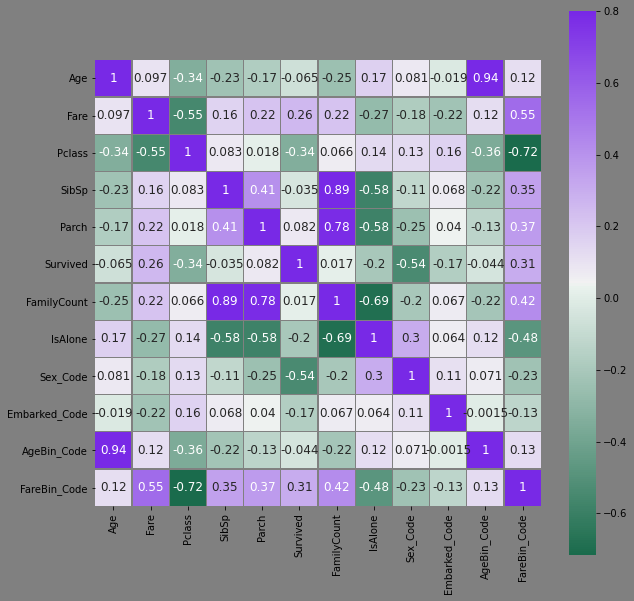

In [9]:
'''
EDA + partially cleaning the data
check for NaN (null) data by columns
'''
# show some plots
# Age boxplot and stacked histogram (Continuous)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.set_facecolor('gray')
axs[0].boxplot(x=train_features['Age'], showmeans=True)
axs[1].hist(
    x=[train_features[train_features['Survived'] == 0]['Age'], train_features[train_features['Survived'] == 1]['Age']],
    stacked=True, color = ['g','b'], label = ['Survived','Dead']
)

# Embarked barplot (Discrete)
fig = plt.figure(figsize=(5, 5))
fig.set_facecolor('gray')
sns.barplot(x=train_features['Embarked'], y=train_features['Survived'])
fig.show()

# AgeBin pointplot
fig = plt.figure(figsize=(5, 5))
fig.set_facecolor('gray')
sns.pointplot(x=train_features['AgeBin'], y=train_features['Survived'], color='r')
fig.show()

# correlation heatmap of dataset
fig3, axs = plt.subplots(figsize = (10, 10))
color = sns.diverging_palette(150, 275, s=90, l=40, n=14, as_cmap=True)
fig3.set_facecolor('gray')
fig3 = sns.heatmap(
    train_features.corr(), ax=axs,
    cmap=color, square=True,
    linewidths=0.2, vmax=0.8, linecolor='gray',
    annot=True, annot_kws={'fontsize':12}
)
fig3.title('Correlation of Features', y=1, size=20)

In [ ]:
# because Cabin has poor data quality and we are not interested in Embarked, we can just drop them
# table without Cabin and Embarked 
dropped = train.drop(['Cabin', 'Embarked'], axis=1)

# another version of the table without invalid Age value 
filtered_age = dropped[dropped['Age'].notnull()]
print(filtered_age.info())
print(filtered_age.describe())



In [ ]:
test_dropped = test.drop(['Cabin', 'Embarked'], axis=1)

test_filtered_age = test_dropped[test_dropped['Age'].notnull()]
print(test_filtered_age.info())
print(test_filtered_age.describe())


In [ ]:
'''
Visualization (Seaborn: https://seaborn.pydata.org/introduction.html)
'''

# looking at Fare and Age to define their categroy
f, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw=dict(width_ratios=[5, 5]))
axs[0].set_title('Age Distribution', color='white')
axs[0].xaxis.label.set_color('white')
axs[0].yaxis.label.set_color('white')
axs[0].spines['bottom'].set_color('white')
axs[0].spines['left'].set_color('white')
axs[0].tick_params(axis='x', colors='white')
axs[0].tick_params(axis='y', colors='white')
sns.distplot(filtered_age['Age'], ax=axs[0], hist_kws=dict(edgecolor="black", linewidth=2))
axs[1].set_title('Ticket Fare Distribution', color='white')
axs[1].xaxis.label.set_color('white')
axs[1].yaxis.label.set_color('white')
axs[1].spines['bottom'].set_color('white')
axs[1].spines['left'].set_color('white')
axs[1].tick_params(axis='x', colors='white')
axs[1].tick_params(axis='y', colors='white')
sns.distplot(filtered_age['Fare'], ax=axs[1], hist_kws=dict(edgecolor="black", linewidth=2))
plt.savefig('Age_and_Fare_plot')

f, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw=dict(width_ratios=[5, 5]))
sns.histplot(data=test_filtered_age['Age'], ax=axs[0])
sns.histplot(data=test_filtered_age['Fare'], ax=axs[1])

In [ ]:
'''
Obivously, Fare has some outliers that need to be removed
'''
f, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw=dict(width_ratios=[5, 5]))

filtered_age = filtered_age[filtered_age["Fare"]<300]
sns.histplot(data=filtered_age['Fare'], ax=axs[0])

test_filtered_age = test_filtered_age[test_filtered_age["Fare"]<300]
sns.histplot(data=test_filtered_age['Fare'], ax=axs[1])



In [ ]:
'''
build classifier (Scikit-Learn: https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn)
'''


# first define (encode) the features 
# we are interested in the following features: Sex, Age, passenger class, fare

names = ['Sex', 'Age', 'Pclass', 'Fare']
features = filtered_age[['Sex', 'Age', 'Pclass', 'Fare']].to_numpy()

# training list 
label = filtered_age['Survived'].to_numpy()

# testing features 
test_features = test_filtered_age[['Sex', 'Age', 'Pclass', 'Fare']].to_numpy()

# varify they are the same shape 
assert(features.shape[0] == label.shape[0])

'''
Once we are all good with our data, we can encode them using sklearn
'''

# encode the labeling features
# this convert string, boolean data into int
le = preprocessing.LabelEncoder()

# Sex needs to be encoded 
sex_encoded = le.fit_transform([feature[0] for feature in features])
test_sex_encoded = le.fit_transform([t_feature[0] for t_feature in test_features])

assert(sex_encoded.shape[0] == label.shape[0])


# all the other features are already in int or floats
# now we merge the encoded feature back 
for i in range(len(features)):
    features[i][0] = sex_encoded[i]

for i in range(len(test_features)):
    test_features[i][0] = test_sex_encoded[i]

'''
Age and Fare needs to be converted into catagorical data 
conversion rule: 
* (Age) 0: [0-5]; 1: [6-11]; ...; total of 8 levels --> Age // 5
* (Fare) 0: [0-10]; 1: [11-21]; ...; total of 28 levels --> Fare // 10
'''
for feature in features:
    # catagorizes Age
    feature[1] = feature[1] // 5
    # catagorizes Fare
    feature[3] = feature[3] // 10

for test_feature in test_features:
    # catagorizes Age
    test_feature[1] = test_feature[1] // 5
    # catagorizes Fare
    test_feature[3] = test_feature[3] // 10 


# print(np.isnan(np.sum(test_features)))



In [ ]:
'''
fit the model with Sex alone
'''

gnb_sex = GaussianNB()
gnb_sex.fit([[i] for i in sex_encoded], label)

prediction = gnb_sex.predict([[i] for i in test_sex_encoded])
prediction